# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, MaxNLocator
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE


#to ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Reading dataset

In [2]:
data= pd.read_csv('credit_risk_dataset.csv')
data.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


# Knowing shape of dataset

In [4]:
data.shape

(32581, 12)

# Understanding datatypes

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


# Data cleaning

In [6]:
data.isnull().sum() #Explore Null Values

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [7]:
#(Person_emp_length-- (895/32581)*100 = 2.7% is missing/null value -- we can remove them.

data.dropna(subset=['person_emp_length'], inplace=True)

# Segment wise imputation for 'loan_int_rate'

In [8]:
mean_loan_int_rate = data.groupby('loan_grade')['loan_int_rate'].mean().reset_index()  #Calculating mean of each loan grade
print(mean_loan_int_rate)

#Imputing mean_loan_int_rate where null

data['loan_int_rate'] = data['loan_int_rate'].fillna(data.groupby('loan_grade')['loan_int_rate'].transform('mean'))
data.isnull().sum()

  loan_grade  loan_int_rate
0          A       7.347094
1          B      11.002471
2          C      13.453041
3          D      15.348901
4          E      17.005655
5          F      18.597321
6          G      20.251525


person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

# Statistical Summary

In [9]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
person_age,31686.0,27.747302,6.360283,20.00,23.00,26.000000,30.000000,144.00
person_income,31686.0,66691.878306,62427.286689,4000.00,39397.00,56000.000000,80000.000000,6000000.00
person_emp_length,31686.0,4.789686,4.142630,0.00,2.00,4.000000,7.000000,123.00
loan_amnt,31686.0,9661.337815,6336.226458,500.00,5000.00,8000.000000,12500.000000,35000.00
loan_int_rate,31686.0,11.038304,3.208064,5.42,7.90,11.002471,13.453041,23.22
loan_status,31686.0,0.215426,0.411124,0.00,0.00,0.000000,0.000000,1.00
loan_percent_income,31686.0,0.169612,0.106297,0.00,0.09,0.150000,0.230000,0.83
cb_person_cred_hist_length,31686.0,5.809316,4.060867,2.00,3.00,4.000000,8.000000,30.00


1.person_age- * No missing value , mean 27.73 indicating young population, *min 20 and max 144 is unusual, (Need to investigate 144 and treat it as possible outlier) 2. person_income - *No missing value, * Mean indicating middle income family, * higher max value indication possible outlier or data entry , (I will investigate the high income, as it will distort analysis. Will also consider log transformation or categorize income for effective modelling) 3. person_emp_length-- *missing values , *max value being suspicious. (Will investigate the max employment length and treat null values.) 4.loan amount-- * no missing values , *min and max values seems reasonable (Whole distribution of this data looks normal. Investigating relationship between loan amount and person income could give a better insight into credit risk.) 5. loan_int_rate --missing value * min and max range is 5.42-23.22 , indicating higher interest rate being higher risk , (Considering imputing missing value using segment wise imputing ) 6.loan_status -- * no missing value , * mean 0.21 indicating 21% loans are not fully paid . 7. loan_percent_income - *no missing value , * mean value 0.17 indicating on an average 17% of people's income is allocated for loan repayment. (High loan percentage indicates higher risk. Considering analyzing how this metric corelates with loan status and interest rate. ) 8. cb_person_cred_hist_length - * no missing value , *min/max ranges 2-30 y rs. (Higher his length suggest lower risk . Considering analyzing it with loan status and interest rate for assessing the risk better.)


# Feature Engineering
Create New Features Relevant to Credit Eligibility

a. Creating Feature for the group who has no employment length but has income

In [14]:
#Entries with 0 'person_emp_length'

zero_emp_length = data[data['person_emp_length'] == 0].shape[0]
print(f"Number of entries with employment_length of 0 is  {zero_emp_length}")
#feature engg
data['has_income_no_emp'] = np.where((data['person_income'] > 0) & (data['person_emp_length'] == 0), 1, 0)
data['has_income_no_emp'] = data['has_income_no_emp'].astype(str)

#1 indicates that the person has income but no employment length.
#0 means that the person has employment length.

Number of entries with employment_length of 0 is  4105


b. Age Group Identification

In [15]:
data['age_group'] = pd.cut(data['person_age'], bins=[0 , 15, 25 , 45, 65, 90, 150] , labels=['0-15', '16-25','26-45', '46-65', '66-90' ,'91-150'])

data['age_group'] = data['age_group'].astype(str)

c. Income Range Identification

In [16]:
data['income_range'] = pd.cut(data['person_income'], [0, 50000, 100000, 200000, 400000 ,600000, 800000, 1000000, 3000000]
                            , labels= ['0-50000','50001-100000', '100001-200000', '200001-400000', '400001-600000', '600001-800000', '800001-1000000',  '1000001-3000000'] )

data['income_range'] = data['income_range'].astype(str)

# Show the filtered result
data.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,has_income_no_emp,age_group,income_range
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3,0,16-25,50001-100000
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2,0,16-25,0-50000
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3,0,16-25,0-50000
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2,0,16-25,50001-100000
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4,0,16-25,50001-100000


# Removing Outlier
a. Removing Outlier from Person_emp_length

In [17]:
data = data[data['person_emp_length'] != 123]

b. Removing Outlier from person_age

In [18]:
# Remove rows where the age group is '91-150' for realistic analysis/Outlier removal
data= data[data['age_group'] != '91-150']

data.describe().T


,count,mean,std,min,25%,50%,75%,max
person_age,31678.0,27.728581,6.202358,20.00,23.00,26.000000,30.000000,84.00
person_income,31678.0,66491.440495,52769.086293,4000.00,39396.00,56000.000000,80000.000000,2039784.00
person_emp_length,31678.0,4.782183,4.034956,0.00,2.00,4.000000,7.000000,41.00
loan_amnt,31678.0,9660.062188,6334.435654,500.00,5000.00,8000.000000,12500.000000,35000.00
loan_int_rate,31678.0,11.038079,3.208167,5.42,7.90,11.002471,13.453041,23.22
loan_status,31678.0,0.215449,0.411140,0.00,0.00,0.000000,0.000000,1.00
loan_percent_income,31678.0,0.169607,0.106269,0.00,0.09,0.150000,0.230000,0.83
cb_person_cred_hist_length,31678.0,5.808542,4.058028,2.00,3.00,4.000000,8.000000,30.00


In [19]:
#Exporting clean data as new file
data.to_csv('cleaned_credit_risk_dataset.csv', index=False)

df= pd.read_csv('cleaned_credit_risk_dataset.csv')
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,has_income_no_emp,age_group,income_range
0,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2,0,16-25,0-50000
1,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3,0,16-25,0-50000
2,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2,0,16-25,50001-100000
3,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4,0,16-25,50001-100000
4,21,9900,OWN,2.0,VENTURE,A,2500,7.14,1,0.25,N,2,0,16-25,0-50000


# Exploratory Data Analysis
# Univariate Analysis

Categorical univariate analysis

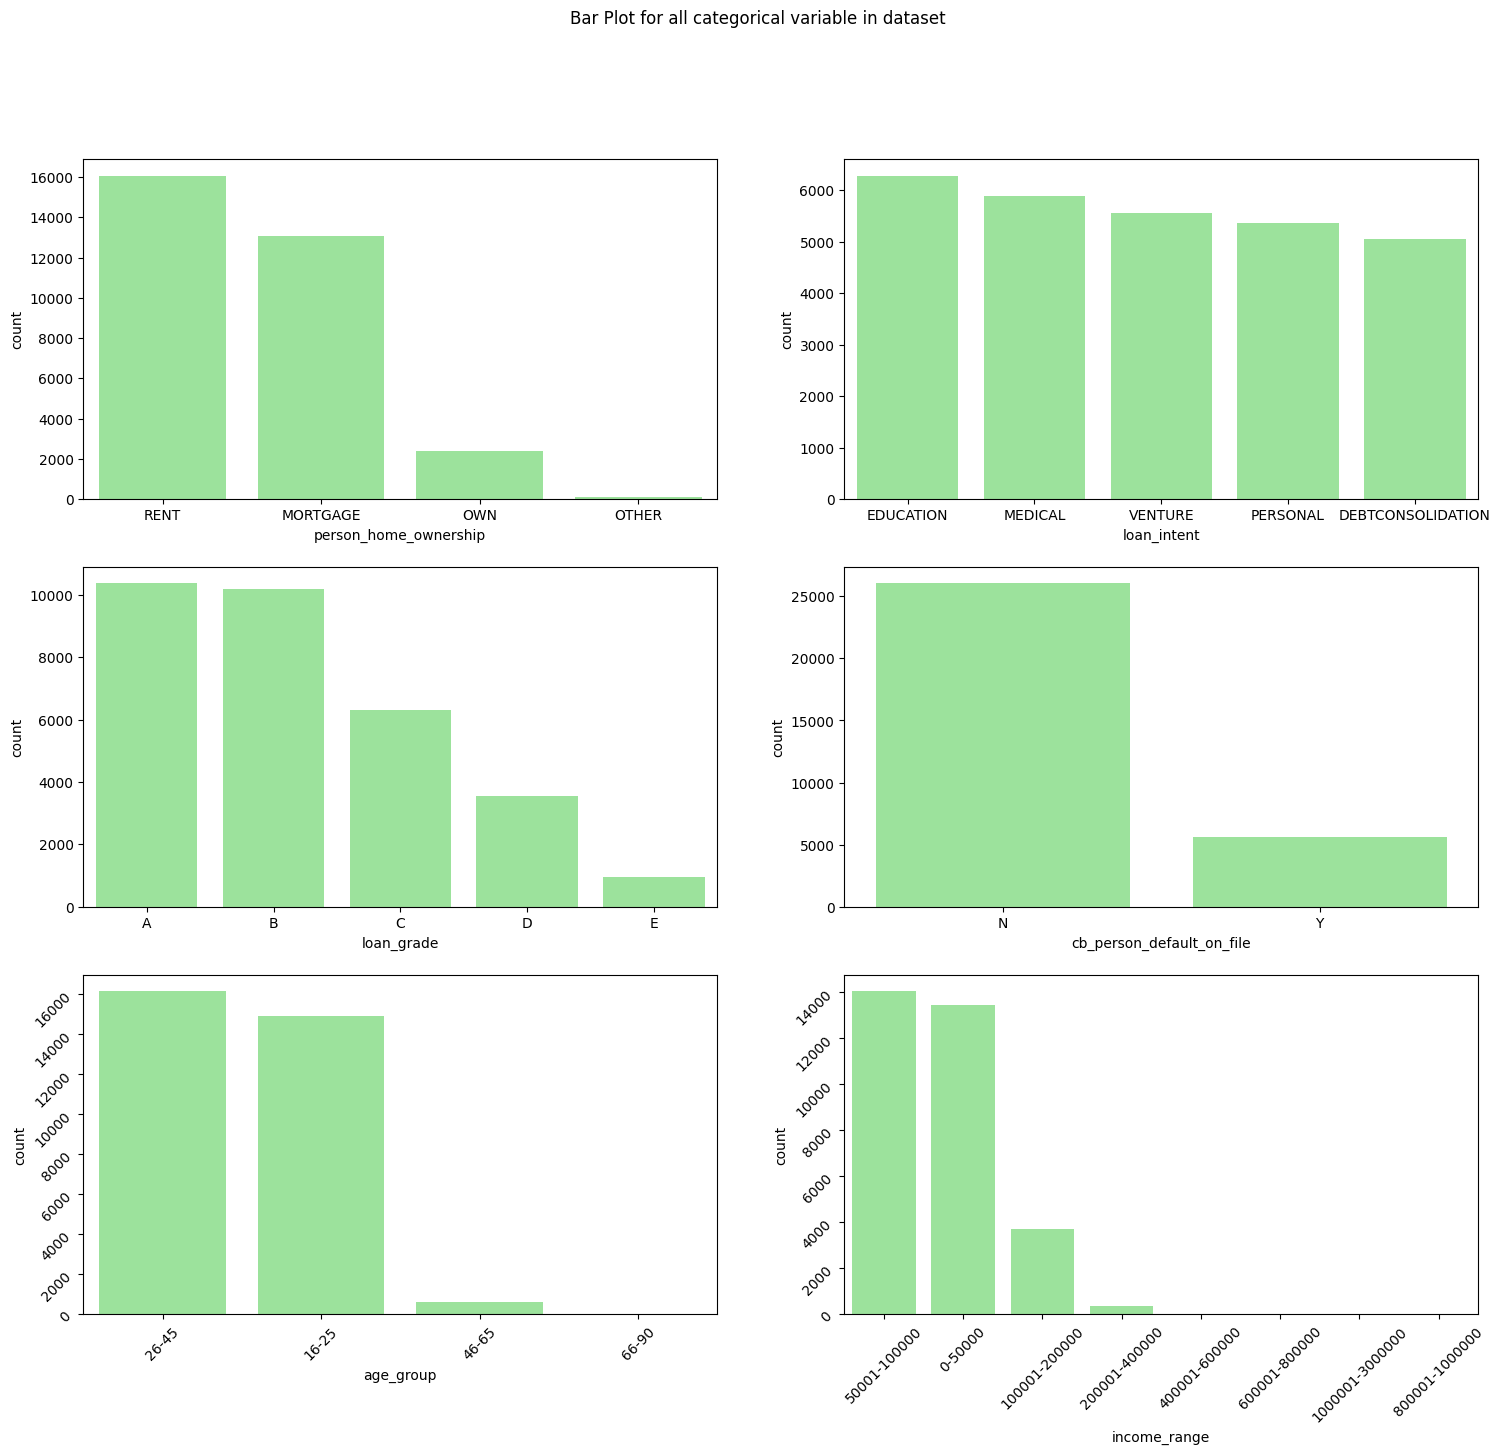

In [21]:
cat_col = ['person_home_ownership','loan_intent','loan_grade','loan_status','cb_person_default_on_file','age_group','income_range']

fig,axes = plt.subplots(3,2,figsize= (18,15))
fig.suptitle('Bar Plot for all categorical variable in dataset')

sns.countplot(ax=axes[0,0],x=df['person_home_ownership']
            ,color='lightgreen', order = df['person_home_ownership'].value_counts().index)
sns.countplot(ax=axes[0,1],x=df['loan_intent']
              ,color='lightgreen',order = df['loan_intent'].value_counts().head(5).index)
sns.countplot(ax=axes[1,0],x=df['loan_grade']
              ,color='lightgreen',order = df['loan_grade'].value_counts().head(5).index)
sns.countplot(ax=axes[1,1],x=df['cb_person_default_on_file']
              ,color='lightgreen',order = df['cb_person_default_on_file'].value_counts().index)
sns.countplot(ax=axes[2,0],x=df['age_group']
              ,color='lightgreen',order = df['age_group'].value_counts().index)
sns.countplot(ax=axes[2,1],x=df['income_range']
              ,color='lightgreen',order = df['income_range'].value_counts().index)

axes[2][0].tick_params(labelrotation=45);
axes[2][1].tick_params(labelrotation=45);

plt.show()

Numerical Analysis

person_age
skew: 1.92


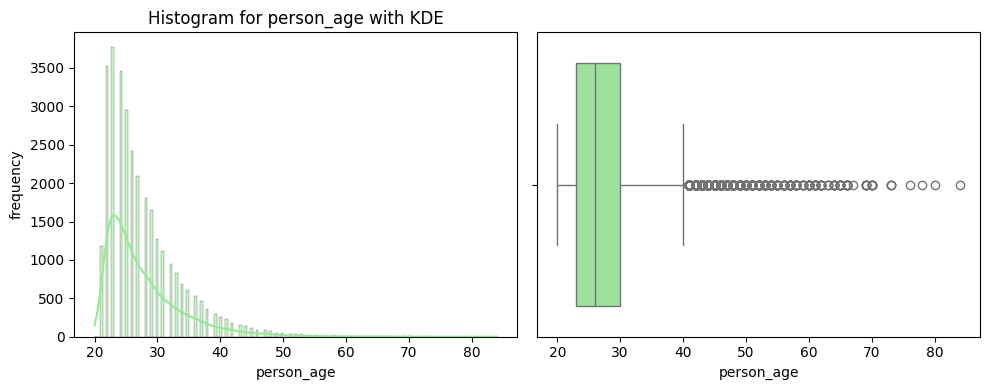

person_income
skew: 9.82


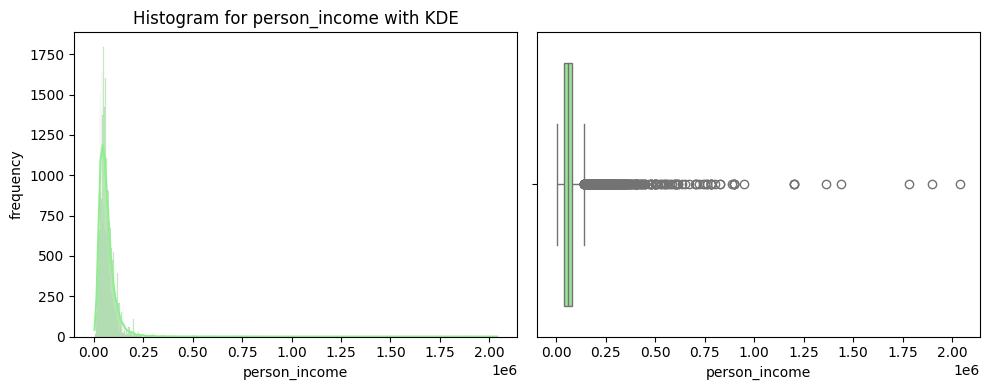

person_emp_length
skew: 1.25


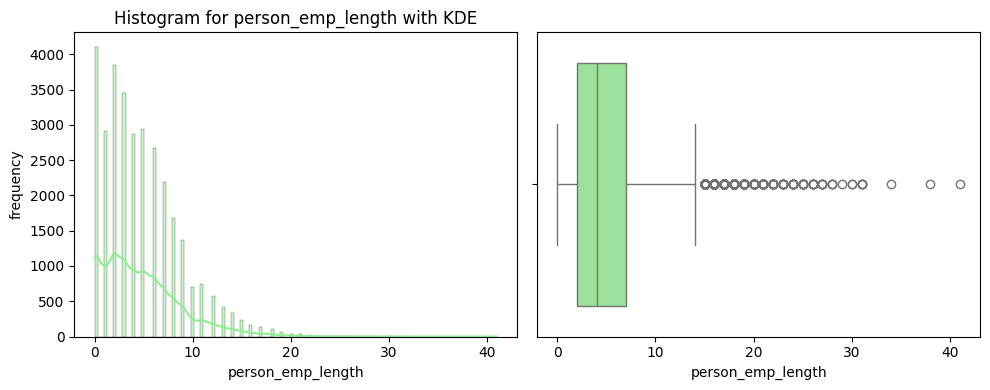

loan_amnt
skew: 1.18


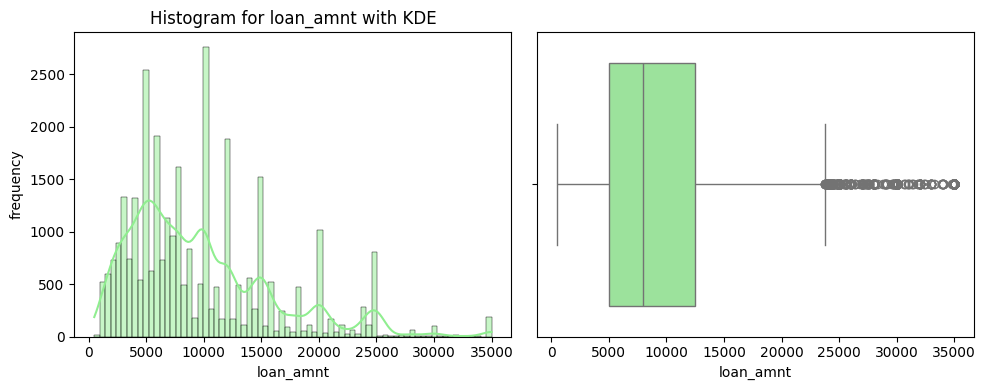

loan_int_rate
skew: 0.21


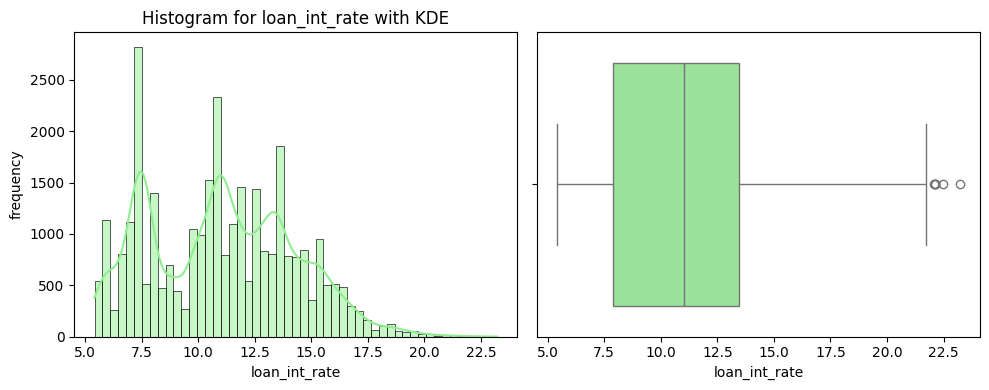

loan_percent_income
skew: 1.07


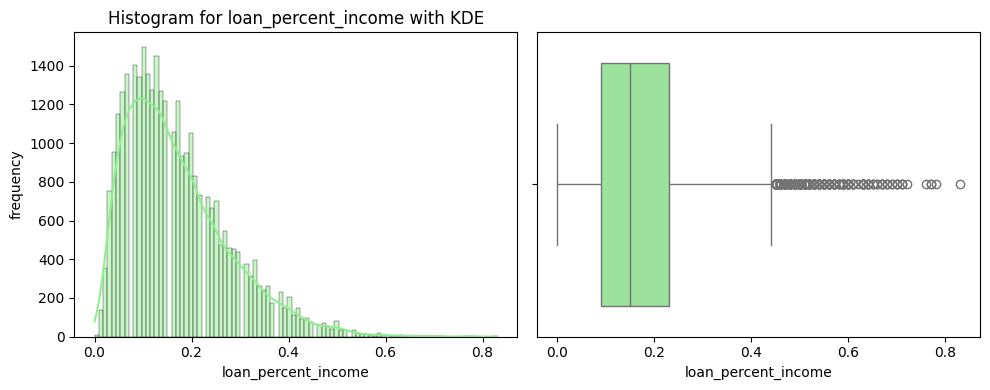

cb_person_cred_hist_length
skew: 1.66


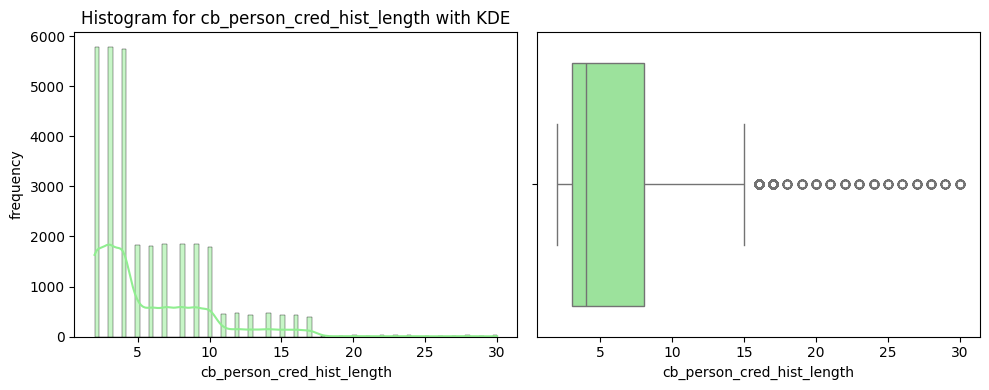

In [22]:
num_col = ['person_age', 'person_income' , 'person_emp_length', 'loan_amnt' , 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length' ]
for col in num_col:
  print(col)
  print ('skew:' ,round(df[col].skew(),2))

#For Histogram :
  plt.figure(figsize=(10, 4))
  plt.subplot(1, 2, 1)

  sns.histplot(df[col], kde=True, color='lightgreen')
  plt.ylabel('frequency')
  plt.title(f'Histogram for {col} with KDE')

#For Boxplot
  plt.subplot(1,2,2)
  sns.boxplot(x=df[col], color ='lightgreen')
  plt.tight_layout()
  plt.show()


# b. Bivariate Analysis
Categorical variable vs target variable

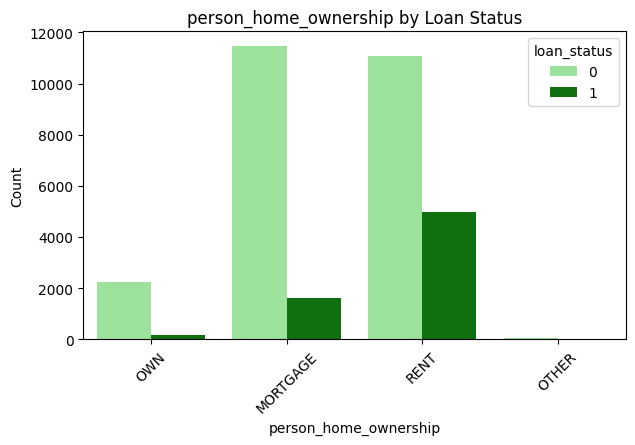

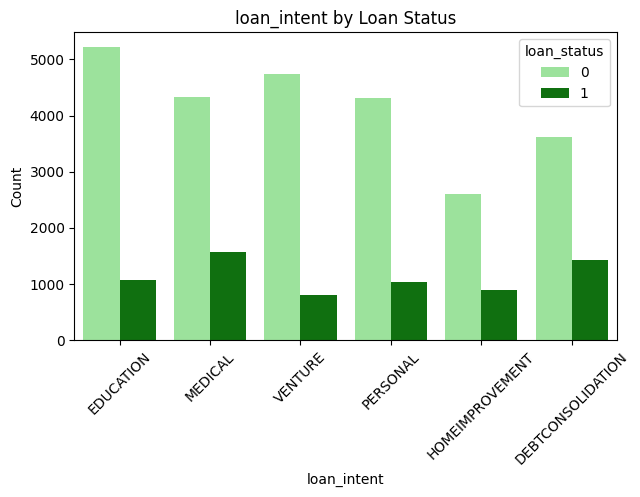

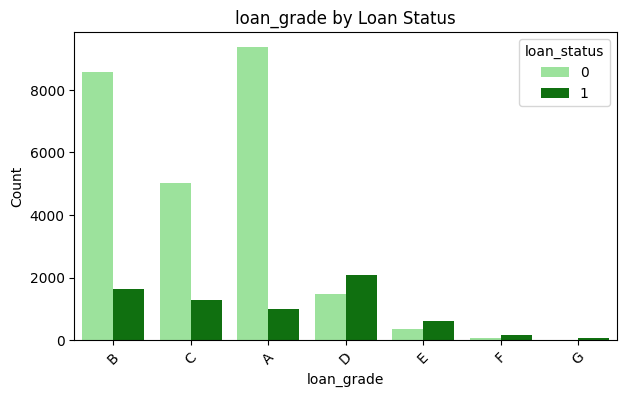

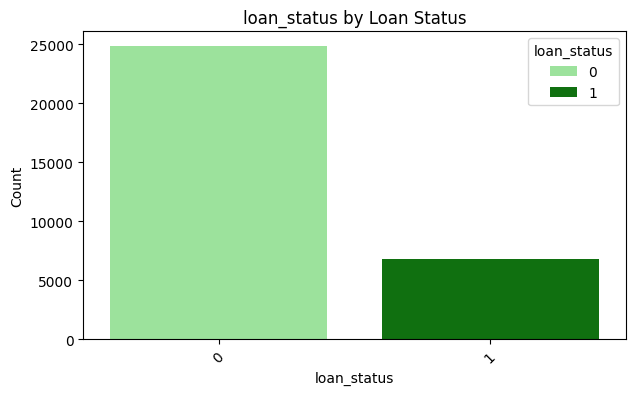

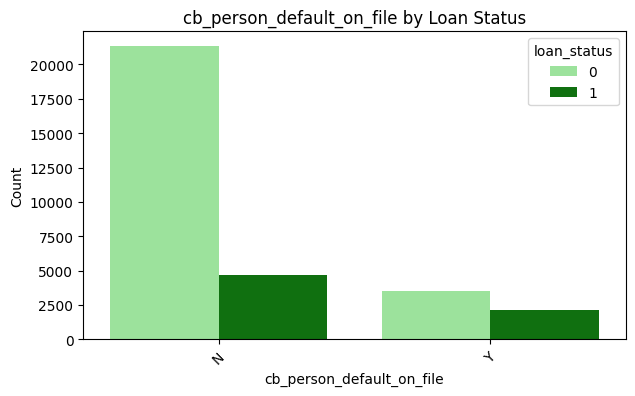

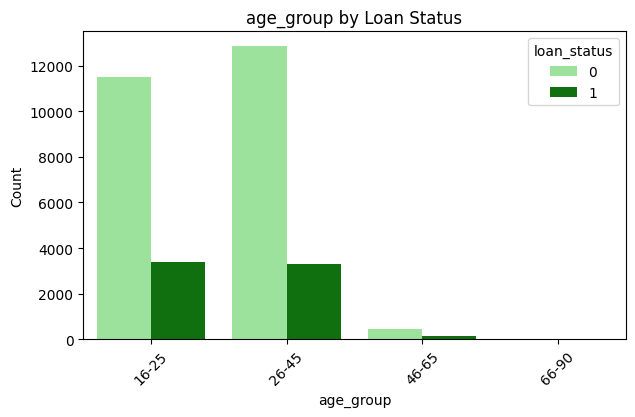

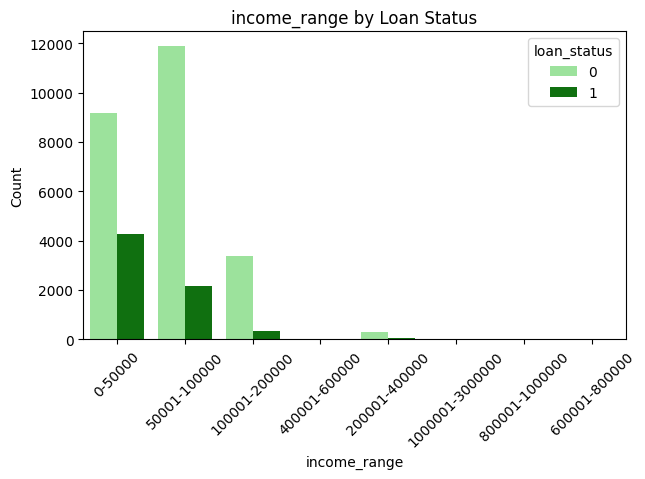

In [23]:
for col in cat_col:
    plt.figure(figsize=(7, 4))
    sns.countplot(x=col, hue='loan_status', data=df, palette=["lightgreen", "green"])
    plt.title(f'{col} by Loan Status')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

Numerical against target variable

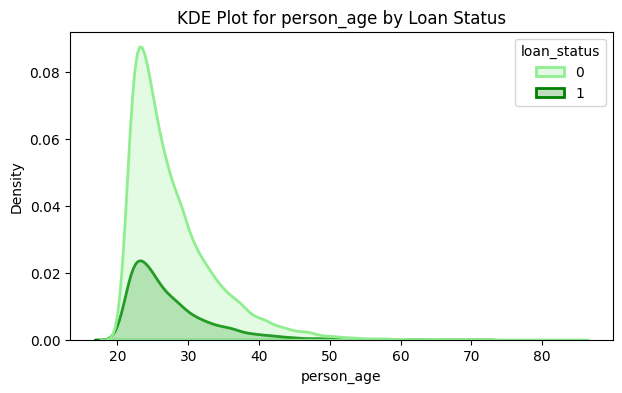

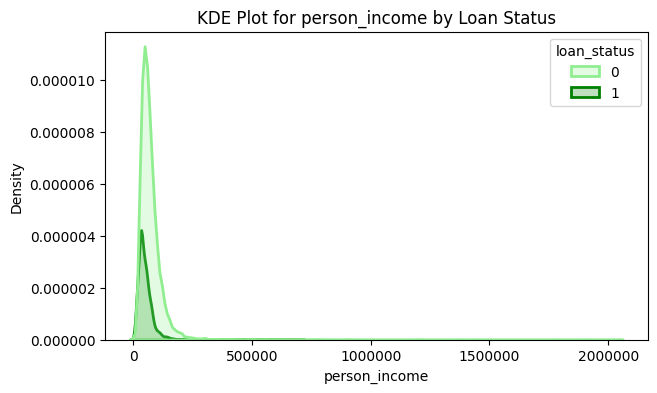

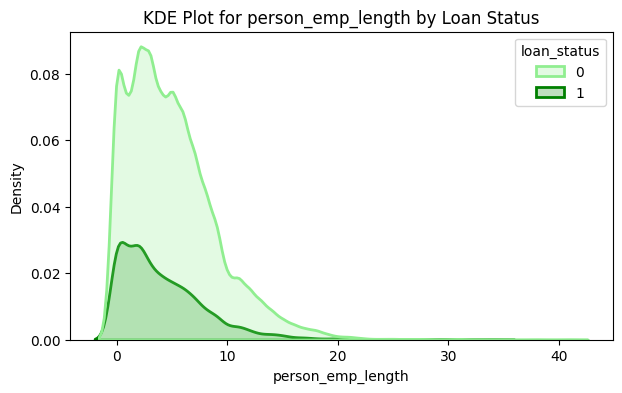

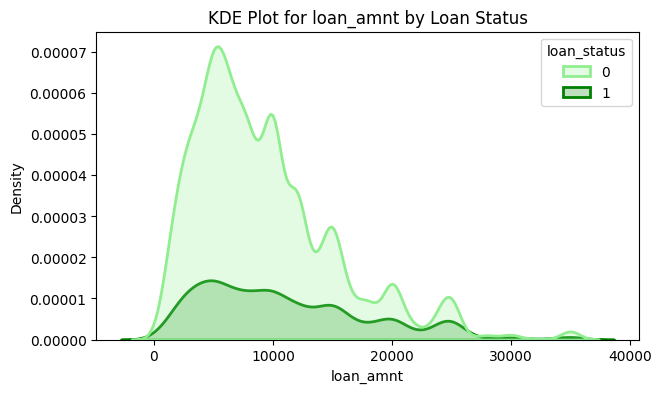

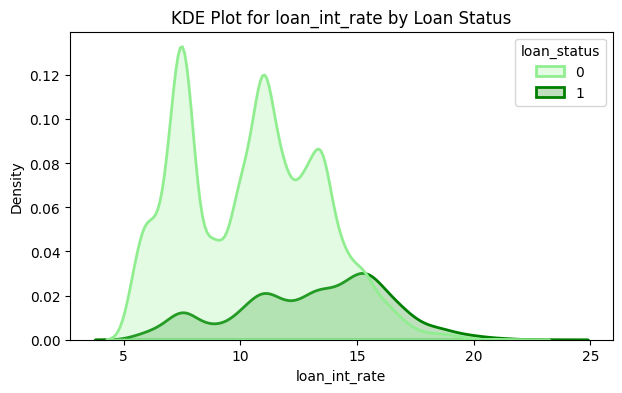

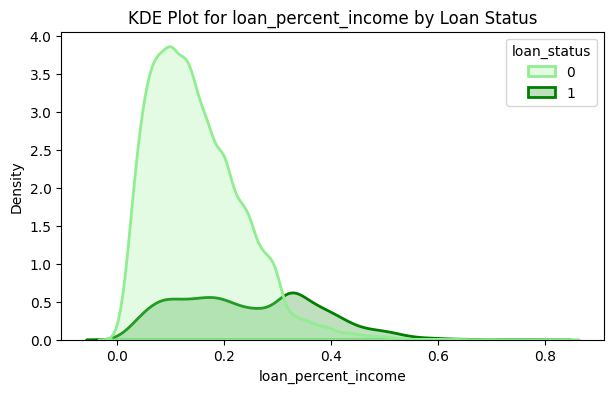

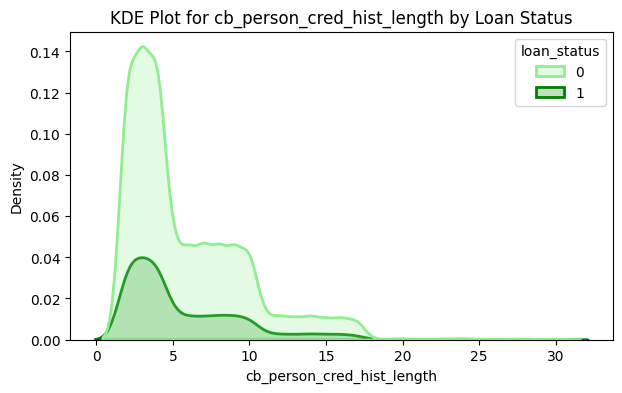

In [24]:
for col in num_col:
#Density plot

    plt.figure(figsize=(7, 4))
    # KDE plot for loan_status = 0 and 1
    sns.kdeplot(data=df, x=col, hue='loan_status', fill=True, palette=['lightgreen', 'green'], linewidth=2)
    plt.title(f'KDE Plot for {col} by Loan Status')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.ticklabel_format(style='plain')

# c. Multivariate Analysis
Correlation Matrix

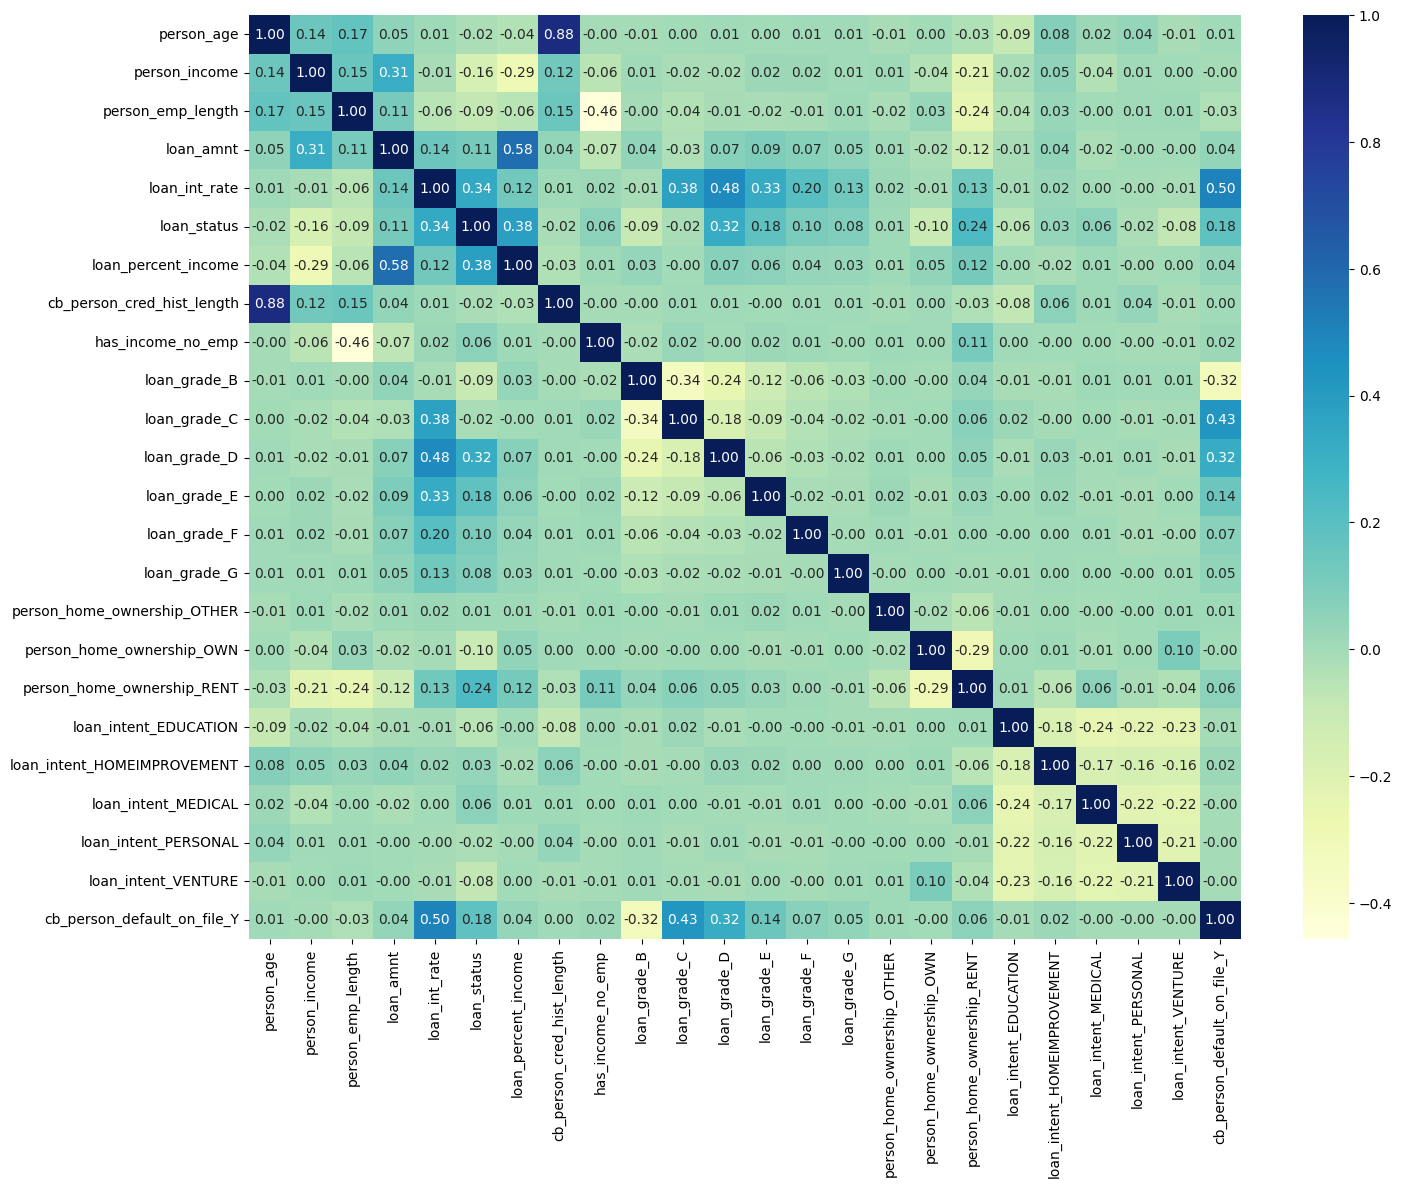

In [25]:
columns_to_exclude = ['age_group', 'income_range']  # Specify columns to exclude
df_corr = df.drop(columns=columns_to_exclude)

# Convert categorical variables to numeric
df_encoded = pd.get_dummies(df_corr, columns=['loan_grade' ,'person_home_ownership','loan_intent','cb_person_default_on_file'], drop_first=True)

# Include the target variable (loan_status) in the correlation analysis
correlation_matrix = df_encoded.corr()
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, cmap="YlGnBu", fmt=".2f")
plt.show()

Investigating most corelated variable with loan_status

Loan Interest Rate

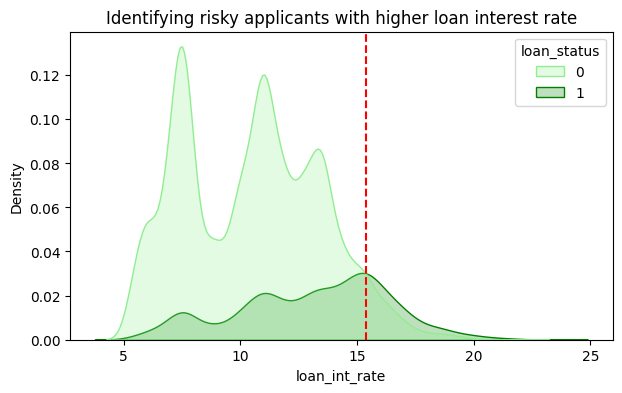

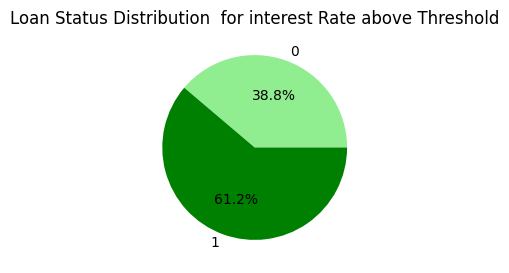

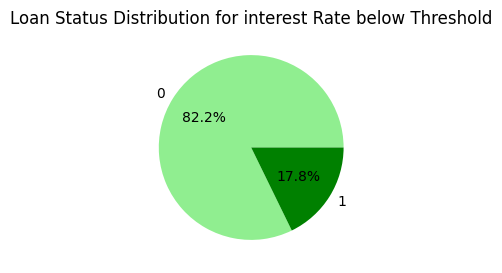

In [27]:
#Setting Threshold of higher default
plt.figure(figsize=(7, 4))
sns.kdeplot(data=df, x='loan_int_rate', hue='loan_status', fill=True, palette=['lightgreen', 'green'])
plt.title("Identifying risky applicants with higher loan interest rate")
plt.axvline(x=15.4, color='red', linestyle='--', label='Potential Threshold')
plt.show()

loan_int_above_threshold = df[df['loan_int_rate'] >= 15.4]
loan_int_below_threshold = df[df['loan_int_rate'] < 15.4]

loan_status_for_higher_int_rate = loan_int_above_threshold.groupby('loan_status').size()
loan_status_for_lower_int_rate = loan_int_below_threshold.groupby('loan_status').size()

plt.figure(figsize=(3, 3))
loan_status_for_higher_int_rate.plot(kind='pie', autopct='%1.1f%%', colors=['lightgreen', 'green'])
plt.title('Loan Status Distribution  for interest Rate above Threshold')

plt.figure(figsize=(3, 3))
loan_status_for_lower_int_rate.plot(kind='pie', autopct='%1.1f%%', colors=['lightgreen', 'green'])
plt.title('Loan Status Distribution for interest Rate below Threshold')
plt.show()
     


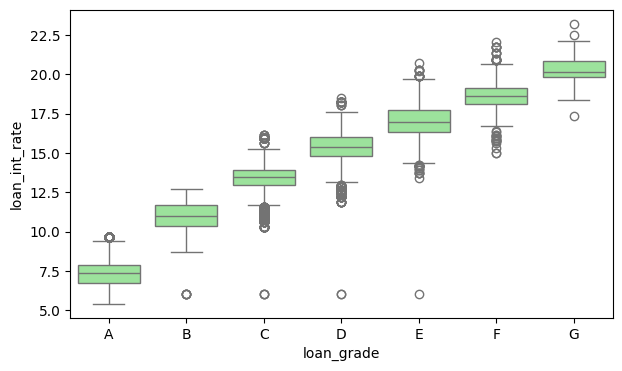

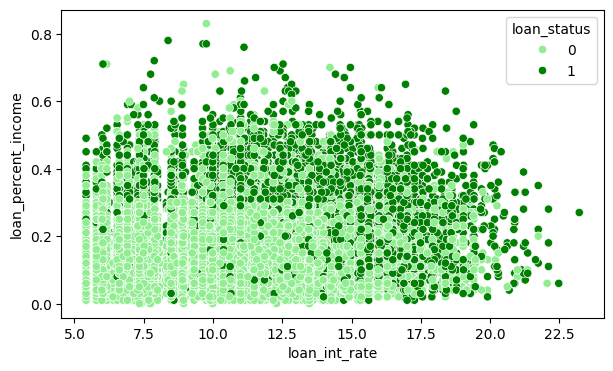

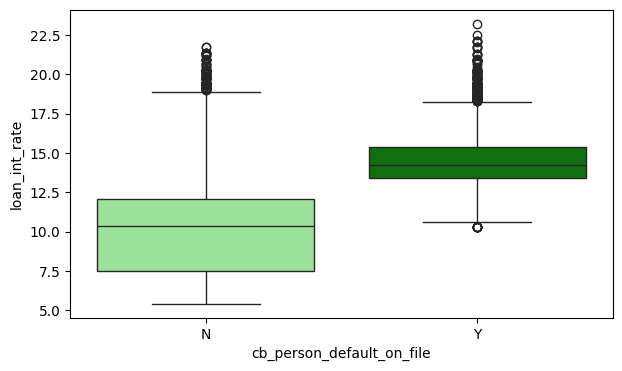

In [28]:
# Create a boxplot to visualize the distribution of loan interest rates across different loan grades
plt.figure(figsize=(7, 4))
sns.boxplot(x='loan_grade', y='loan_int_rate', data=df, palette=['lightgreen'], order=sorted(df['loan_grade'].unique()))
plt.show()

# Boxplot of loan_percent_income by loan interest rate
plt.figure(figsize=(7, 4))
sns.scatterplot(x='loan_int_rate', y='loan_percent_income', data=df, hue= 'loan_status', palette=['lightgreen','green'])
plt.show()

# Assuming 'previous_defaults' is a binary feature (1 = defaulted before, 0 = no default)
plt.figure(figsize=(7, 4))
sns.boxplot(x='cb_person_default_on_file', y='loan_int_rate', data=df, palette=['lightgreen','green'])
plt.show()

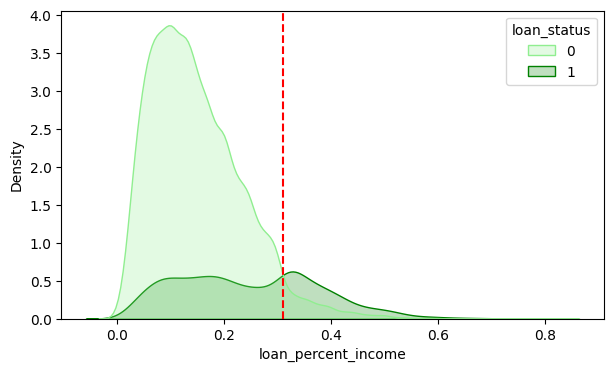

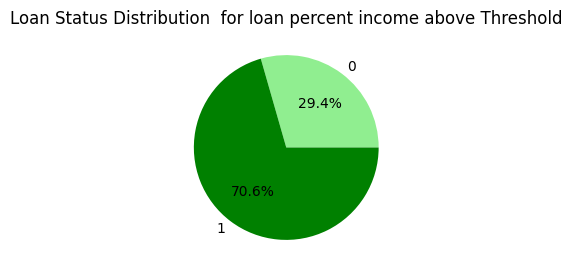

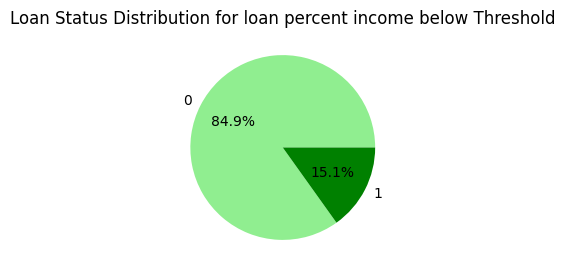

In [29]:
plt.figure(figsize=(7, 4))
sns.kdeplot(data=df, x='loan_percent_income', hue='loan_status', fill=True, palette=['lightgreen', 'green'])
plt.axvline(x=0.31, color='red', linestyle='--', label='Potential Threshold')
plt.show()

loan_percent_income_above_threshold = df[df['loan_percent_income'] >= 0.31]
loan_percent_income_below_threshold = df[df['loan_percent_income'] < 0.31]

loan_status_for_higher_loan_percent_income = loan_percent_income_above_threshold.groupby('loan_status').size()
loan_status_for_lower_loan_percent_income = loan_percent_income_below_threshold.groupby('loan_status').size()

plt.figure(figsize=(3, 3))
loan_status_for_higher_loan_percent_income.plot(kind='pie', autopct='%1.1f%%', colors=['lightgreen', 'green'])
plt.title('Loan Status Distribution  for loan percent income above Threshold')

plt.figure(figsize=(3, 3))
loan_status_for_lower_loan_percent_income.plot(kind='pie', autopct='%1.1f%%', colors=['lightgreen', 'green'])
plt.title('Loan Status Distribution for loan percent income below Threshold')
plt.show()
     

In [30]:
# Create crosstab to see default rates by age and income
crosstab = pd.crosstab([df['age_group'],df['income_range'] ], df['loan_status'], normalize='index')
print(crosstab)

loan_status                       0         1
age_group income_range                       
16-25     0-50000          0.673938  0.326062
          100001-200000    0.933539  0.066461
          200001-400000    0.905660  0.094340
          400001-600000    1.000000  0.000000
          50001-100000     0.844468  0.155532
26-45     0-50000          0.695659  0.304341
          1000001-3000000  1.000000  0.000000
          100001-200000    0.894399  0.105601
          200001-400000    0.869565  0.130435
          400001-600000    0.857143  0.142857
          50001-100000     0.847026  0.152974
          600001-800000    0.764706  0.235294
          800001-1000000   1.000000  0.000000
46-65     0-50000          0.650246  0.349754
          1000001-3000000  1.000000  0.000000
          100001-200000    0.863636  0.136364
          200001-400000    0.888889  0.111111
          400001-600000    1.000000  0.000000
          50001-100000     0.835570  0.164430
          600001-800000    1.00000

In [31]:
renters_with_zero_emp_defaulting = df[(df['person_home_ownership'] == 'RENT') & (df['person_emp_length'] == 0) & (df['loan_status'] == 1)]
num_of_renters=  df[(df['person_home_ownership'] == 'RENT') & (df['person_emp_length'] == 0)]

num_renters_zero_emp_defaulting = renters_with_zero_emp_defaulting.shape[0]
total_renters =num_of_renters.shape[0]

# Print the number of renters who is missing employment history
print(f"Number of total renters with Zero Employment length: {total_renters:.2f}")

#print(f"Number of Renters with Employment length: {num_renters_with_emp_defaulting:.2f}")
print(f"Number of renters defaulting with Zero Employment length: {num_renters_zero_emp_defaulting}")

Number of total renters with Zero Employment length: 2666.00
Number of renters defaulting with Zero Employment length: 929


# Flagging risk factors 

In [34]:
grade_mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 6}
default_mapping = {'Y': 1, 'N': 0}
ownership_mapping= {'OWN': 1, 'MORTGAGE' : 2, 'RENT' : 3, 'OTHER' : 4 }

df['loan_grade_numeric'] = df['loan_grade'].map(grade_mapping)
df['prvs_default_numeric'] = df['cb_person_default_on_file'].map(default_mapping)
df['person_home_ownership_numeric'] = df['person_home_ownership'].map(ownership_mapping)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['loan_grade_numeric', 'loan_int_rate', 'loan_percent_income', 'prvs_default_numeric','person_home_ownership_numeric']])
df[['scaled_loan_grade_numeric', 'scaled_loan_int_rate', 'scaled_loan_percent_income', 'scaled_prvs_default_numeric','scaled_person_home_ownership_numeric']] = scaled_data

df['composite_risk_score'] = (
    (0.3 * df['scaled_loan_percent_income']) +
    (0.25 * df['scaled_loan_int_rate']) +
    (0.2 * df['scaled_loan_grade_numeric']) +
    (0.15 * df['scaled_person_home_ownership_numeric']) +
    (0.1 * df['scaled_prvs_default_numeric']))

bins = [0, 0.3, 0.5, 0.7, 1]  # Define bins for risk categories
labels = ['Low Risk', 'Medium Risk', 'High Risk', 'Very High Risk']
df['risk_category'] = pd.cut(df['composite_risk_score'], bins=bins, labels=labels)

df.head(15)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,...,loan_grade_numeric,prvs_default_numeric,person_home_ownership_numeric,scaled_loan_grade_numeric,scaled_loan_int_rate,scaled_loan_percent_income,scaled_prvs_default_numeric,scaled_person_home_ownership_numeric,composite_risk_score,risk_category
0,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,...,2,0,1,0.2,0.321348,0.120482,0.0,0.000000,0.156482,Low Risk
1,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,...,3,0,2,0.4,0.418539,0.686747,0.0,0.333333,0.440659,Medium Risk
2,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,...,3,0,3,0.4,0.551124,0.638554,0.0,0.666667,0.509347,High Risk
3,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,...,3,1,3,0.4,0.497191,0.662651,1.0,0.666667,0.603093,High Risk
4,21,9900,OWN,2.0,VENTURE,A,2500,7.14,1,0.25,...,1,0,1,0.0,0.096629,0.301205,0.0,0.000000,0.114519,Low Risk
5,26,77100,RENT,8.0,EDUCATION,B,35000,12.42,1,0.45,...,2,0,3,0.2,0.393258,0.542169,0.0,0.666667,0.400965,Medium Risk
6,24,78956,RENT,5.0,MEDICAL,B,35000,11.11,1,0.44,...,2,0,3,0.2,0.319663,0.530120,0.0,0.666667,0.378952,Medium Risk
7,24,83000,RENT,8.0,PERSONAL,A,35000,8.90,1,0.42,...,1,0,3,0.0,0.195506,0.506024,0.0,0.666667,0.300684,Medium Risk
8,21,10000,OWN,6.0,VENTURE,D,1600,14.74,1,0.16,...,4,0,1,0.6,0.523596,0.192771,0.0,0.000000,0.308730,Medium Risk
9,22,85000,RENT,6.0,VENTURE,B,35000,10.37,1,0.41,...,2,0,3,0.2,0.278090,0.493976,0.0,0.666667,0.357715,Medium Risk


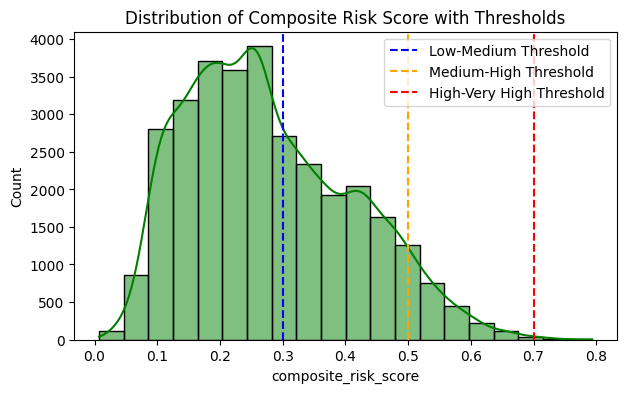

In [35]:
plt.figure(figsize=(7, 4))
sns.histplot(df['composite_risk_score'], bins=20, kde=True, color='green')
plt.axvline(x=0.3, color='blue', linestyle='--', label='Low-Medium Threshold')
plt.axvline(x=0.5, color='orange', linestyle='--', label='Medium-High Threshold')
plt.axvline(x=0.7, color='red', linestyle='--', label='High-Very High Threshold')
plt.legend()
plt.title("Distribution of Composite Risk Score with Thresholds")
plt.show()

In [36]:
features_to_drop = ['age_group','scaled_loan_grade_numeric', 'scaled_loan_int_rate', 'scaled_loan_percent_income', 'scaled_prvs_default_numeric','scaled_person_home_ownership_numeric','loan_amnt' , 'loan_grade_numeric',
                    'prvs_default_numeric','person_home_ownership_numeric','has_income_no_emp','income_range','risk_category']

df.drop(columns=features_to_drop, inplace=True)
df.head(5)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,composite_risk_score
0,21,9600,OWN,5.0,EDUCATION,B,11.14,0,0.10,N,2,0.156482
1,25,9600,MORTGAGE,1.0,MEDICAL,C,12.87,1,0.57,N,3,0.440659
2,23,65500,RENT,4.0,MEDICAL,C,15.23,1,0.53,N,2,0.509347
3,24,54400,RENT,8.0,MEDICAL,C,14.27,1,0.55,Y,4,0.603093
4,21,9900,OWN,2.0,VENTURE,A,7.14,1,0.25,N,2,0.114519


# Predictive Model
1.RandomForestClassifier

In [37]:
# Perform train-test split
X = df.drop(['loan_status'], axis=1)
y = df['loan_status']  # Define the target variable

X = pd.get_dummies(X, drop_first=True)

# Now you can proceed with train-test split and model training as before

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)


# Apply StandardScaler to your dataset
scaler = StandardScaler()

# Fit and transform the training set
X_train = scaler.fit_transform(X_train)

# Transform the test set
X_test = scaler.transform(X_test)

#Building & training the model
model= RandomForestClassifier(class_weight='balanced', n_estimators =100, random_state =42)
model.fit(X_train, y_train)

#Making Prediction
y_pred = model.predict(X_test)
#Evaluating model

accuracy= accuracy_score(y_test , y_pred)
print(f"\nModel Accuracy : {accuracy:.2f}")

#classification report

print(classification_report(y_test, y_pred))


y_prob = model.predict_proba(X_test)[:, 1]  # This gives the probabilities for class 1 (the positive class)

fpr, tpr, thresholds = roc_curve(y_test, y_prob) #find the optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold}")

#y_pred_adjusted = (y_prob >= optimal_threshold).astype(int)
print(confusion_matrix(y_test, y_pred))

feature_importances = model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)


Model Accuracy : 0.93
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      7456
           1       0.96      0.71      0.82      2048

    accuracy                           0.93      9504
   macro avg       0.94      0.85      0.89      9504
weighted avg       0.93      0.93      0.93      9504

Optimal Threshold: 0.3
[[7397   59]
 [ 586 1462]]
                        Feature  Importance
6          composite_risk_score    0.190302
4           loan_percent_income    0.179951
1                 person_income    0.152107
3                 loan_int_rate    0.120078
2             person_emp_length    0.054991
0                    person_age    0.051454
9    person_home_ownership_RENT    0.041783
5    cb_person_cred_hist_length    0.040532
17                 loan_grade_D    0.036751
16                 loan_grade_C    0.019298
14          loan_intent_VENTURE    0.014942
11  loan_intent_HOMEIMPROVEMENT    0.014563
8     person_home_ownership_

2.KNeighborsClassifier

In [38]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=6)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy= accuracy_score(y_test , y_pred)
print(f"\nModel Accuracy : {accuracy:.2f}")

print(classification_report(y_test, y_pred))
y_prob = model.predict_proba(X_test)[:, 1]  # This gives the probabilities for class 1 (the positive class)

fpr, tpr, thresholds = roc_curve(y_test, y_prob) #find the optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold}")

#y_pred_adjusted = (y_prob >= optimal_threshold).astype(int)
print(confusion_matrix(y_test, y_pred))


Model Accuracy : 0.90
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      7456
           1       0.92      0.59      0.72      2048

    accuracy                           0.90      9504
   macro avg       0.91      0.79      0.83      9504
weighted avg       0.90      0.90      0.89      9504

Optimal Threshold: 0.3333333333333333
[[7345  111]
 [ 842 1206]]


3. LogisticRegression

In [39]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy= accuracy_score(y_test , y_pred)
print(f"\nModel Accuracy : {accuracy:.2f}")

print(classification_report(y_test, y_pred))

y_prob = model.predict_proba(X_test)[:, 1]  # This gives the probabilities for class 1 (the positive class)

fpr, tpr, thresholds = roc_curve(y_test, y_prob) #find the optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold}")

#y_pred_adjusted = (y_prob >= optimal_threshold).astype(int)
print(confusion_matrix(y_test, y_pred))


Model Accuracy : 0.87
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      7456
           1       0.77      0.54      0.64      2048

    accuracy                           0.87      9504
   macro avg       0.83      0.75      0.78      9504
weighted avg       0.86      0.87      0.86      9504

Optimal Threshold: 0.28803677359261626
[[7132  324]
 [ 933 1115]]


4. DecisionTreeClassifier

In [40]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


accuracy= accuracy_score(y_test , y_pred)
print(f"\nModel Accuracy : {accuracy:.2f}")
print(classification_report(y_test, y_pred))

y_prob = model.predict_proba(X_test)[:, 1]  # This gives the probabilities for class 1 (the positive class)

fpr, tpr, thresholds = roc_curve(y_test, y_prob) #find the optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold}")

#y_pred_adjusted = (y_prob >= optimal_threshold).astype(int)
print(confusion_matrix(y_test, y_pred))


feature_importances = model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)


     


Model Accuracy : 0.89
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      7456
           1       0.73      0.77      0.75      2048

    accuracy                           0.89      9504
   macro avg       0.84      0.85      0.84      9504
weighted avg       0.89      0.89      0.89      9504

Optimal Threshold: 1.0
[[6888  568]
 [ 474 1574]]
                        Feature  Importance
4           loan_percent_income    0.233619
3                 loan_int_rate    0.160222
1                 person_income    0.132489
9    person_home_ownership_RENT    0.124601
6          composite_risk_score    0.068371
2             person_emp_length    0.051465
0                    person_age    0.039814
16                 loan_grade_C    0.035698
5    cb_person_cred_hist_length    0.029737
12          loan_intent_MEDICAL    0.023246
11  loan_intent_HOMEIMPROVEMENT    0.022439
17                 loan_grade_D    0.020949
13         loan_intent_PERSO

5. GradientBoostingClassifier

In [42]:
!pip install xgboost
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy= accuracy_score(y_test , y_pred)
print(f"\nModel Accuracy : {accuracy:.2f}")
print(classification_report(y_test, y_pred))

y_prob = model.predict_proba(X_test)[:, 1]  # This gives the probabilities for class 1 (the positive class)

fpr, tpr, thresholds = roc_curve(y_test, y_prob) #find the optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold}")

#y_pred_adjusted = (y_prob >= optimal_threshold).astype(int)
print(confusion_matrix(y_test, y_pred))


   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   - -------------------------------------- 4.7/150.0 MB 25.0 MB/s eta 0:00:06
   -- ------------------------------------- 9.4/150.0 MB 23.8 MB/s eta 0:00:06
   --- ------------------------------------ 13.4/150.0 MB 22.2 MB/s eta 0:00:07
   ---- ----------------------------------- 17.6/150.0 MB 21.5 MB/s eta 0:00:07
   ----- ---------------------------------- 21.5/150.0 MB 21.1 MB/s eta 0:00:07
   ------ --------------------------------- 25.7/150.0 MB 20.8 MB/s eta 0:00:06
   ------- -------------------------------- 29.9/150.0 MB 20.6 MB/s eta 0:00:06
   --------- ------------------------------ 33.8/150.0 MB 20.5 MB/s eta 0:00:06
   ---------- ----------------------------- 38.0/150.0 MB 20.3 MB/s eta 0:00:06
   ----------- ---------------------------- 41.9/150.0 MB 20.2 MB/s eta 0:00:06
   ------------ --------------------------- 45.9/150.0 MB 20.2 MB/s eta 0:00:06
   ------------- -------------------------- 50.1/15